# Import Important Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import pickle
from matplotlib.ticker import FixedLocator

# Important Functions

In [2]:
def model_evaluation(y_test, y_pred):

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AI', 'Human'])

    disp.plot()

    plt.show()

    # Assuming y_test and y_pred are your actual and predicted labels respectively
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Extracting the confusion matrix components
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Calculate the F1-score
    f1 = f1_score(y_test, y_pred)
    
    # Calculate the false positive rate and false negative rate
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    
    print("\nAdditional Metrics:")
    print(f"F1-score: {f1:.2f}")
    print(f"False Positive Rate (FPR): {fpr:.2f}")
    print(f"False Negative Rate (FNR): {fnr:.2f}")
    print(f"True Positive Rate (TPR): {tpr:.2f}")
    print(f"True Negative Rate (TNR): {tnr:.2f}")
    
    # Extract the number of actual mistakes (false predictions)
    actual_mistakes = fp + fn
    
    print("\nTotal number of actual mistakes:", actual_mistakes)
    print(actual_mistakes/len(y_pred))

In [31]:
def testing(text, model):
    label_mapping = {0: 'Human', 1: 'AI'}
    embeded_text = processed_dataset_obj.preprocessing_text(text).reshape(1, -1)
    embeded_text_df = pd.DataFrame(embeded_text)
    embeded_text_df.columns = [f"feature_{i}" for i in range(1, embeded_text_df.shape[1] + 1)]
    transformed_data = fdr.transform_single_data_point(embeded_text_df)
    prediction = model.predict(transformed_data)
    predicted_label = label_mapping[prediction[0]] + " Generated"
    return predicted_label

In [4]:
def count_plot(dataset):

    # Define the label mapping with integer keys
    label_mapping = {0: 'Human', 1: 'AI'}
    
    # Create the countplot
    ax = sns.countplot(x='label', data=dataset)
    
    # Set fixed ticks and tick labels based on the mapping
    ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
    ax.set_xticklabels([label_mapping[int(label.get_text())] for label in ax.get_xticklabels()])
    
    # Annotate each bar with the count
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}',  # The count value
            (p.get_x() + p.get_width() / 2, p.get_height()),  # Position of the text
            ha='center',
            va='bottom'
        )
    ax.set_xlabel('Category')  
    ax.set_ylabel('Count')     
    
    # Show the plot
    plt.show()

# Loading Dataset

In [3]:
def get_dataset_df(human_dataset_path, ai_dataset_path):
    dataset_paths = [human_dataset_path, ai_dataset_path]
    result_df = pd.DataFrame()
    
    for dataset_path in dataset_paths:

        label = 1 if dataset_path.split('\\')[-1] == 'AI' else 0 ## 1 for AI generated text and 0 for human generated text
        
        csv_files = [os.path.join(dataset_path, file_name) for file_name in os.listdir(dataset_path) 
                if file_name.endswith(".csv")]
        
        for csv_file in csv_files:
            data = pd.read_csv(csv_file)
            data['label'] = label
            result_df = pd.concat([result_df, data], ignore_index=True)
    result_df = result_df.drop(columns = ['uid'])
    result_df = result_df.drop_duplicates()
    result_df = result_df.sample(frac=1).reset_index(drop=True)
            
    return result_df

In [4]:
ai_dataset_path = r"Dataset\AI"
human_dataset_path = r"Dataset\Human"
dataset = get_dataset_df(human_dataset_path, ai_dataset_path)

In [6]:
dataset.shape

(58537, 2)

In [7]:
dataset.head()

,text,label
0,GOP-ers are complaining that McCain isn't doin...,0
1,The Union cabinet has cleared the merger of Ra...,0
2,Last week's birth of Prince George was widely ...,1
3,Orlando has struggled to buy a small family-ow...,1
4,"Reagan McCarthy, a 20-year-old student at Penn...",1


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58537 entries, 0 to 58536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    58537 non-null  object
 1   label   58537 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 914.8+ KB


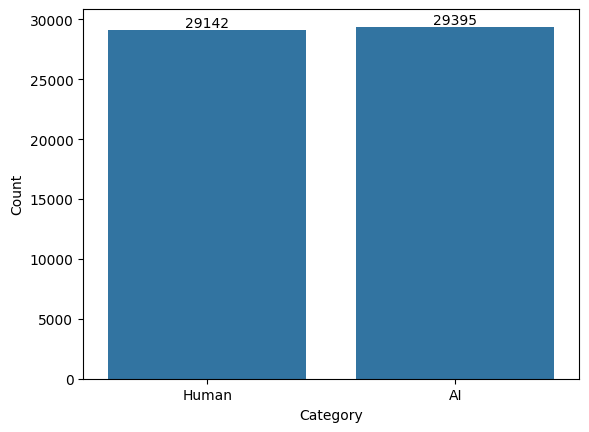

In [14]:
count_plot(dataset)

# Selecting 10000 smaples with equal class

In [31]:
dataset.shape

(58537, 2)

In [32]:
def sampling_the_dataset(dataset, num_samples, random_state=42):
    class_0_samples = num_samples//2
    class_1_samples = num_samples - class_0_samples
    
    dataset_0 = dataset[dataset['label'] == 0]
    sampled_dataset_0 = dataset_0.sample(class_0_samples, random_state=random_state)
    
    dataset_1 = dataset[dataset['label'] == 1]
    sampled_dataset_1 = dataset_1.sample(class_1_samples, random_state=random_state)

    combined_dataset = pd.concat([sampled_dataset_0, sampled_dataset_1], axis=0, ignore_index=True)

    shuffled_dataset = combined_dataset.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return shuffled_dataset

In [33]:
dataset_10000 = sampling_the_dataset(dataset, 10000)

In [34]:
dataset_10000.shape

(10000, 2)

In [40]:
dataset_10000.head()

,text,label
0,Newt Gingrich has demanded an apology from NBC...,1
1,Ok - there are some very good answers here but...,0
2,Bexar County Commissioners Tuesday solidified ...,0
3,Image copyright INS News Agency Image caption ...,0
4,We've spent some time looking at the conspirac...,0


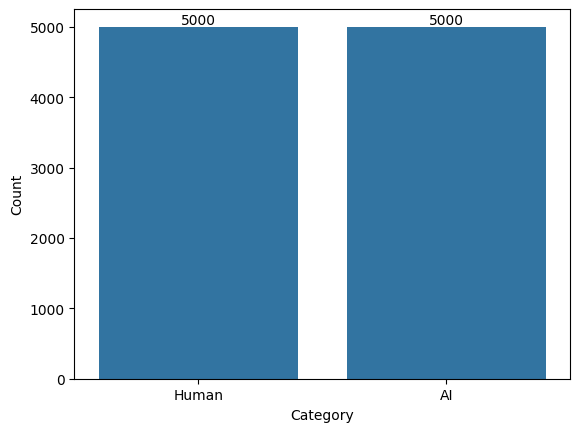

In [41]:
count_plot(dataset_10000)

# Data Preprocessing Transformer Based Embeddings

In [37]:
import torch
from transformers import AutoTokenizer, AutoModel

In [33]:
class TextEmbedding:

    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.max_length = self.tokenizer.model_max_length

    def convert_text_to_tokenid(self, text):
        tokens = self.tokenizer(text, return_tensors="pt")
        token_ids = tokens["input_ids"].squeeze().tolist()
        return token_ids

    def convert_tokenid_to_tokens(self, token_ids):
        tokens_str = self.tokenizer.convert_ids_to_tokens(token_ids)
        return tokens_str

    def get_vocabulary(self):
        return self.tokenizer.get_vocab()

    def convert_tokenid_to_text(self, token_ids):
        reconstructed_text = self.tokenizer.decode(token_ids)
        return reconstructed_text

    def cosine_similarity(self, input1, input2):
        embeddings1 = self.encode(input1)
        embeddings2 = self.encode(input2)
        similarity_score = F.cosine_similarity(embeddings1, embeddings2)
        return round(similarity_score.item(), 4)
        
    def encode(self, text):
        
        tokens = self.tokenizer(text, return_tensors="pt")
        input_ids = tokens['input_ids'][0]  # Extract the input IDs
        num_chunks = (len(input_ids) // self.max_length) + 1
        chunks = [input_ids[i * self.max_length: (i + 1) * self.max_length] for i in range(num_chunks)]
    
        embeddings = []

        # Process each chunk
        for chunk in chunks:
            chunk_tensor = chunk.unsqueeze(0)  # Add batch dimension (batch, num_tokens)
            with torch.no_grad():
                outputs = self.model(input_ids=chunk_tensor)
                chunk_embedding = outputs.last_hidden_state.mean(dim=1)  # (batch, num_tokens, embeding_size)
            embeddings.append(chunk_embedding)

        con_embedding = torch.cat(embeddings, dim=0)
        combined_embedding = torch.mean(con_embedding, dim=0)
            
        return combined_embedding
        
    def decode(self, embedded_text):
        pass

In [35]:
class TextPreprocessing:
    def __init__(self,  model_name = 'gpt2'):
        # self.text_embedding = text_embedding
        self.text_embedding = TextEmbedding(model_name)

    def preprocessing_basic(self, text):
        text = text.lower()
        text = text.replace('\r\n', ' ').replace('\n', '').replace('\r', '').replace('\\', '')
        return text

    def preprocessing_text(self, text):
        text_encoded = self.text_embedding.encode(text)
        text_encoded_flatten = torch.flatten(text_encoded)
        text_encoded_flatten_array = text_encoded_flatten.numpy()
        return text_encoded_flatten_array

    def preprocessing_final(self, dataset):
        # processed_dataset = self.dataset['text'].copy()
        processed_dataset = dataset['text'].apply(self.preprocessing_text)
        dataset_text_df = pd.DataFrame(processed_dataset.tolist())
        dataset_text_df.columns = [f"feature_{i}" for i in range(1, dataset_text_df.shape[1] + 1)]
        processed_dataset = pd.concat([dataset_text_df, dataset['label']], axis = 1)
        return processed_dataset

In [111]:
# text_embedding_obj = TextEmbedding('gpt2')
# text_embedding_obj = TextEmbedding('bert-base-uncased')

In [112]:
# print(text_embedding_obj.max_length)

In [45]:
# dataset_10000.shape

In [38]:
processed_dataset_obj = TextPreprocessing()

In [47]:
# processed_dataset = processed_dataset_obj.preprocessing_final(dataset_10000)

In [62]:
# processed_dataset.to_pickle('Dataset\preprocessed_gpt2_data_10000.pkl')

# Data Tarnsformation and Spliting

In [5]:
preprocessed_data = pd.read_pickle('Dataset\preprocessed_gpt2_data_10000.pkl')

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [41]:
class FeaturesDimensionalityReduction:
    def __init__(self, scaler=None, pca=None):
        self.scaler = scaler or StandardScaler()
        self.pca = pca or PCA()

    def fit(self, X_data, n_components):
        self.scaler.fit(X_data)
        standardized_data = self.scaler.transform(X_data)
        self.pca = PCA(n_components=n_components)
        self.pca.fit(standardized_data)

    def transform_data(self, data):
        standardized_data = self.scaler.transform(data)
        return self.pca.transform(standardized_data)

    def transform_single_data_point(self, data_point):
        return self.transform_data(data_point)

    def save(self, scaler_path="scaler.pkl", pca_path="pca.pkl"):
        with open(scaler_path, "wb") as scaler_file:
            pickle.dump(self.scaler, scaler_file)
        with open(pca_path, "wb") as pca_file:
            pickle.dump(self.pca, pca_file)

    def load(self, scaler_path="scaler.pkl", pca_path="pca.pkl"):
        with open(scaler_path, "rb") as scaler_file:
            self.scaler = pickle.load(scaler_file)
        with open(pca_path, "rb") as pca_file:
            self.pca = pickle.load(pca_file)

In [42]:
preprocessed_data.shape

(10000, 769)

In [43]:
X = preprocessed_data.drop(columns = ['label'])
y = preprocessed_data['label']

In [44]:
X.shape

(10000, 768)

In [46]:
fdr = FeaturesDimensionalityReduction()
fdr.fit(X, 100)


In [47]:
transformed_X_data = fdr.transform_data(X)

In [54]:
transformed_X_data[0][:5]

array([ 6.9083366, -5.462002 , -8.965607 ,  5.713791 , -1.197024 ],
      dtype=float32)

In [49]:
# fdr.save(scaler_path="Model\scaler.pkl", pca_path="Model\pca.pkl")

In [50]:
# fdr.load(scaler_path="Model\scaler.pkl", pca_path="Model\pca.pkl")

In [48]:
transformed_X_data.shape

(10000, 100)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(tr_x, y, test_size=0.20, random_state=42)

In [56]:
print(f"Training dataset : \n  Features shape - {X_train.shape} \n  Target shape - {y_train.shape}")
print(f"Testing dataset : \n  Features shape - {X_test.shape} \n  Target shape - {y_test.shape}")

Training dataset : 
  Features shape - (8000, 100) 
  Target shape - (8000,)
Testing dataset : 
  Features shape - (2000, 100) 
  Target shape - (2000,)


# Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
logistic_regression_model = LogisticRegression(solver='sag', max_iter = 1000)
# logistic_regression_model = LogisticRegression()

In [59]:
logistic_regression_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='sag')

In [60]:
y_pred_test = logistic_regression_model.predict(X_test)

In [61]:
y_pred_train = logistic_regression_model.predict(X_train)

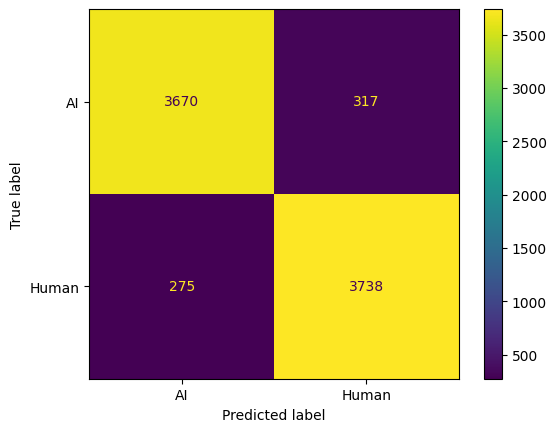


Accuracy: 0.93

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      3987
           1       0.92      0.93      0.93      4013

    accuracy                           0.93      8000
   macro avg       0.93      0.93      0.93      8000
weighted avg       0.93      0.93      0.93      8000


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.08
False Negative Rate (FNR): 0.07
True Positive Rate (TPR): 0.93
True Negative Rate (TNR): 0.92

Summary of Errors:
Total Mistakes (FP + FN): 592
Error Rate: 0.07


In [62]:
model_evaluation(y_train, y_pred_train)

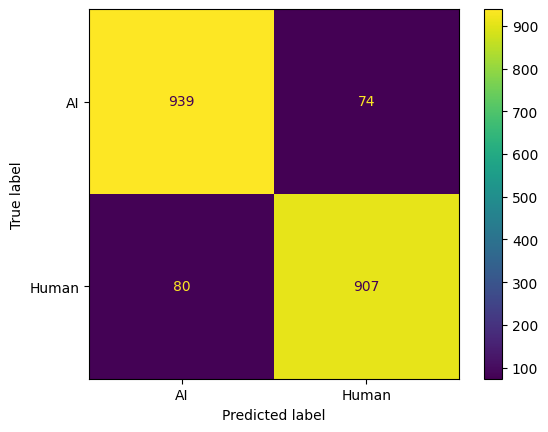


Accuracy: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      1013
           1       0.92      0.92      0.92       987

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.07
False Negative Rate (FNR): 0.08
True Positive Rate (TPR): 0.92
True Negative Rate (TNR): 0.93

Summary of Errors:
Total Mistakes (FP + FN): 154
Error Rate: 0.08


In [63]:
model_evaluation(y_test, y_pred_test)

In [26]:
# Save the model
# with open("Model\logistic_regression_model.pkl", "wb") as file:
    # pickle.dump(logistic_regression_model, file)

In [28]:
# Load the model
with open("Model\logistic_regression_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

In [29]:
new_dataset = """
with due respect what 
"""

In [39]:
pred = testing(new_dataset, loaded_model)

In [40]:
print(pred)

Human Generated


In [94]:
a = np.array([0])
a

array([0])

In [95]:
label_mapping = {0: 'Human', 1: 'AI'} 
label_mapping

{0: 'Human', 1: 'AI'}

In [98]:
label_mapping[a[0]]

'Human'

In [96]:
a[0]

0

# Naive Bayes 

In [114]:
from sklearn.naive_bayes import GaussianNB

In [115]:
guassianNB_classifier = GaussianNB()

In [116]:
guassianNB_classifier.fit(X_train, y_train)

GaussianNB()

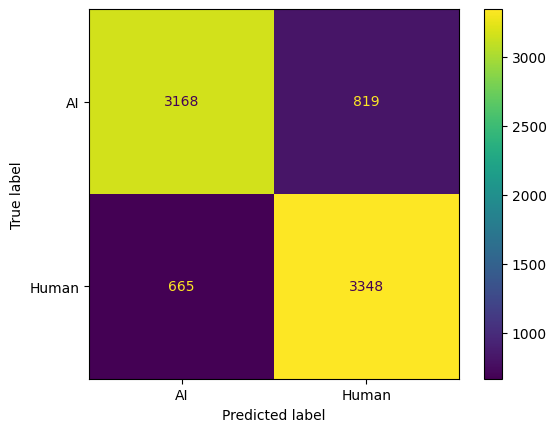


Accuracy: 0.81

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      3987
           1       0.80      0.83      0.82      4013

    accuracy                           0.81      8000
   macro avg       0.81      0.81      0.81      8000
weighted avg       0.81      0.81      0.81      8000


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.21
False Negative Rate (FNR): 0.17
True Positive Rate (TPR): 0.83
True Negative Rate (TNR): 0.79

Summary of Errors:
Total Mistakes (FP + FN): 1484
Error Rate: 0.19


In [117]:
y_pred_train = guassianNB_classifier.predict(X_train)
model_evaluation(y_train, y_pred_train)

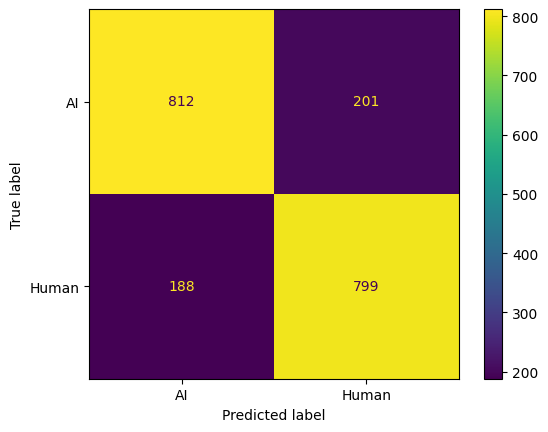


Accuracy: 0.81

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81      1013
           1       0.80      0.81      0.80       987

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.20
False Negative Rate (FNR): 0.19
True Positive Rate (TPR): 0.81
True Negative Rate (TNR): 0.80

Summary of Errors:
Total Mistakes (FP + FN): 389
Error Rate: 0.19


In [118]:
y_pred_test = guassianNB_classifier.predict(X_test)
model_evaluation(y_test, y_pred_test)

# Support Vector Machine

In [119]:
from sklearn.svm import SVC

In [120]:
svm_classifier = SVC()

In [121]:
svm_classifier.fit(X_train, y_train)

SVC()

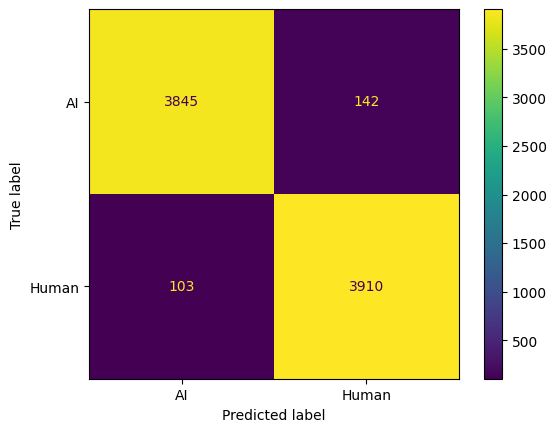


Accuracy: 0.97

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      3987
           1       0.96      0.97      0.97      4013

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.04
False Negative Rate (FNR): 0.03
True Positive Rate (TPR): 0.97
True Negative Rate (TNR): 0.96

Summary of Errors:
Total Mistakes (FP + FN): 245
Error Rate: 0.03


In [122]:
y_pred_train = svm_classifier.predict(X_train)
model_evaluation(y_train, y_pred_train)

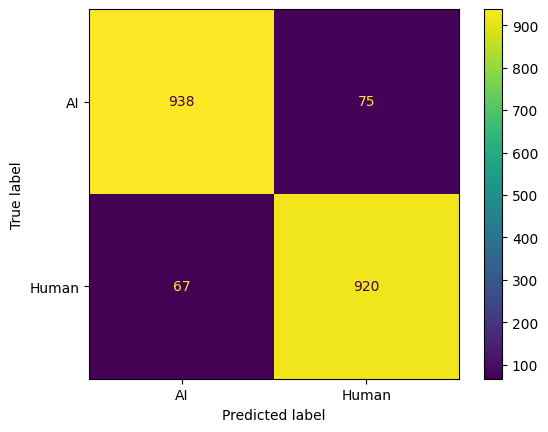


Accuracy: 0.93

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1013
           1       0.92      0.93      0.93       987

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.07
False Negative Rate (FNR): 0.07
True Positive Rate (TPR): 0.93
True Negative Rate (TNR): 0.93

Summary of Errors:
Total Mistakes (FP + FN): 142
Error Rate: 0.07


In [123]:
y_pred_test = svm_classifier.predict(X_test)
model_evaluation(y_test, y_pred_test)

# Random Forest Model

In [139]:
from sklearn.ensemble import RandomForestClassifier

In [140]:
# from sklearn.model_selection import cross_val_score

In [141]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [142]:
random_forest_classifier = RandomForestClassifier()

In [145]:
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [146]:
# scores = cross_val_score(random_forest_classifier, X_train, y_train, cv=5, scoring='accuracy')

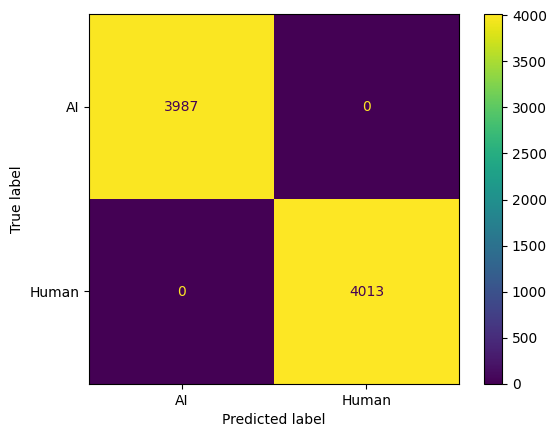


Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3987
           1       1.00      1.00      1.00      4013

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 0.00
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 1.00

Summary of Errors:
Total Mistakes (FP + FN): 0
Error Rate: 0.00


In [147]:
y_pred_train = random_forest_classifier.predict(X_train)
model_evaluation(y_train, y_pred_train)

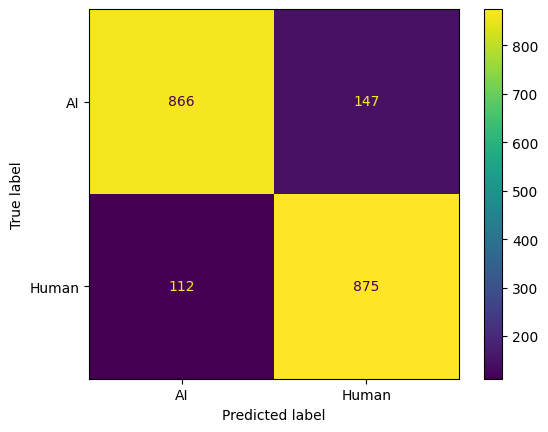


Accuracy: 0.87

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      1013
           1       0.86      0.89      0.87       987

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.15
False Negative Rate (FNR): 0.11
True Positive Rate (TPR): 0.89
True Negative Rate (TNR): 0.85

Summary of Errors:
Total Mistakes (FP + FN): 259
Error Rate: 0.13


In [149]:
y_pred_test = random_forest_classifier.predict(X_test)
model_evaluation(y_test, y_pred_test)

In [174]:
param_space = {
    'n_estimators': Integer(50, 250),
    'max_depth': Integer(10, 70),
    'min_samples_split': Integer(2, 20),
    'criterion' : ('gini', 'entropy', 'log_loss')
}

In [175]:
bayes_search = BayesSearchCV(
    estimator=random_forest_classifier,
    search_spaces=param_space,
    n_iter=30,                  
    cv=5,                       
    scoring='accuracy',         
    random_state=42
)


In [176]:
bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=150),
              n_iter=30, random_state=42, scoring='accuracy',
              search_spaces={'criterion': ('gini', 'entropy', 'log_loss'),
                             'max_depth': (10, 25, 50, 70),
                             'min_samples_split': (2, 10, 20),
                             'n_estimators': (50, 100, 150, 200, 250)})

In [179]:
cv_results = pd.DataFrame(bayes_search.cv_results_)

In [180]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.580787,0.145036,0.015399,0.001358,entropy,50,20,100,"{'criterion': 'entropy', 'max_depth': 50, 'min...",0.82500,0.85625,0.84375,0.84375,0.81250,0.83625,0.015512,15
1,6.756424,0.286201,0.039188,0.005033,log_loss,70,2,250,"{'criterion': 'log_loss', 'max_depth': 70, 'mi...",0.81875,0.85625,0.86875,0.81875,0.80000,0.83250,0.025739,17
2,4.273878,0.312250,0.023393,0.001959,entropy,70,2,150,"{'criterion': 'entropy', 'max_depth': 70, 'min...",0.81875,0.84375,0.87500,0.80000,0.85000,0.83750,0.025921,14
3,6.530433,0.256340,0.035178,0.001466,log_loss,10,10,250,"{'criterion': 'log_loss', 'max_depth': 10, 'mi...",0.84375,0.85000,0.88125,0.83125,0.82500,0.84625,0.019605,5
4,5.303402,0.162794,0.030587,0.004119,log_loss,25,10,200,"{'criterion': 'log_loss', 'max_depth': 25, 'mi...",0.82500,0.86250,0.85625,0.83750,0.82500,0.84125,0.015612,9
5,1.268390,0.012591,0.008198,0.000748,log_loss,70,2,50,"{'criterion': 'log_loss', 'max_depth': 70, 'mi...",0.81250,0.81250,0.81875,0.81875,0.83750,0.82000,0.009186,24
6,6.656054,0.266005,0.035189,0.002322,entropy,70,10,250,"{'criterion': 'entropy', 'max_depth': 70, 'min...",0.85000,0.86875,0.89375,0.82500,0.84375,0.85625,0.023385,1
7,6.484534,0.125587,0.040384,0.011017,entropy,70,10,250,"{'criterion': 'entropy', 'max_depth': 70, 'min...",0.83750,0.85625,0.85625,0.81875,0.83125,0.84000,0.014577,12
8,3.836771,0.351215,0.022989,0.003623,log_loss,50,20,150,"{'criterion': 'log_loss', 'max_depth': 50, 'mi...",0.84375,0.86875,0.86875,0.82500,0.81250,0.84375,0.022707,6
9,2.201889,0.017471,0.015196,0.000400,gini,70,20,100,"{'criterion': 'gini', 'max_depth': 70, 'min_sa...",0.84375,0.83750,0.84375,0.79375,0.81250,0.82625,0.019922,22


In [178]:
print("val. score: ", bayes_search.best_score_)
print("test score: ", bayes_search.score(X_test, y_test))
print("best params: ", bayes_search.best_params_)

val. score:  0.85625
test score:  0.835
best params:  OrderedDict([('criterion', 'entropy'), ('max_depth', 70), ('min_samples_split', 10), ('n_estimators', 250)])


In [181]:
y_pred_test = bayes_search.predict(X_test)

In [134]:
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150)

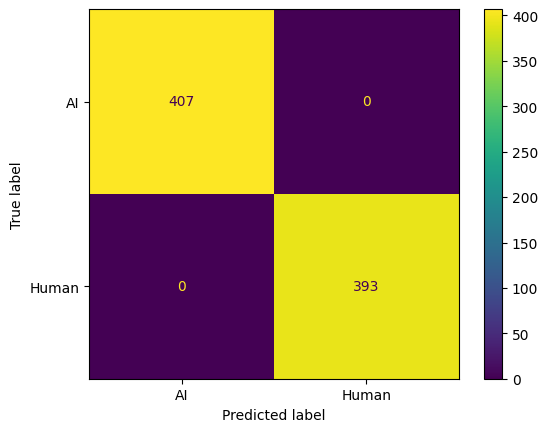


Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       407
           1       1.00      1.00      1.00       393

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 0.00
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 1.00

Summary of Errors:
Total Mistakes (FP + FN): 0
Error Rate: 0.00


In [184]:
model_evaluation(y_train, bayes_search.predict(X_train))

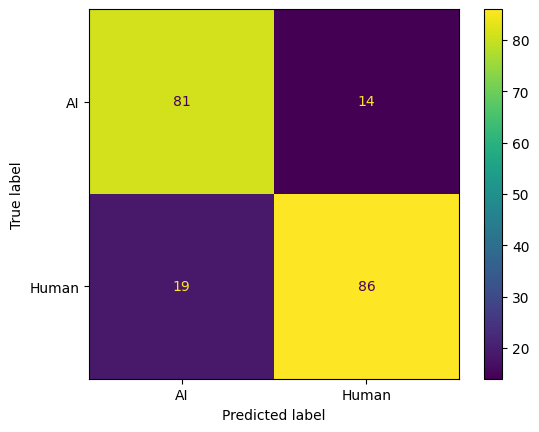


Accuracy: 0.83

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83        95
           1       0.86      0.82      0.84       105

    accuracy                           0.83       200
   macro avg       0.83      0.84      0.83       200
weighted avg       0.84      0.83      0.84       200


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.15
False Negative Rate (FNR): 0.18
True Positive Rate (TPR): 0.82
True Negative Rate (TNR): 0.85

Summary of Errors:
Total Mistakes (FP + FN): 33
Error Rate: 0.17


In [183]:
model_evaluation(y_test, y_pred_test)

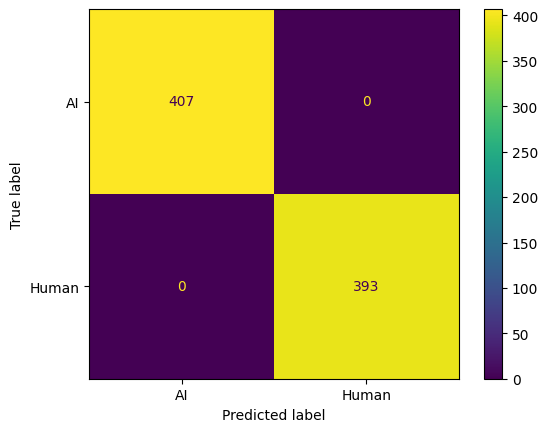

Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       407
           1       1.00      1.00      1.00       393

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 0.00
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 1.00

Summary of Errors:
Total Mistakes (FP + FN): 0
Error Rate: 0.00


In [135]:
y_pred_train = random_forest_classifier.predict(X_train)
model_evaluation(y_train, y_pred_train)

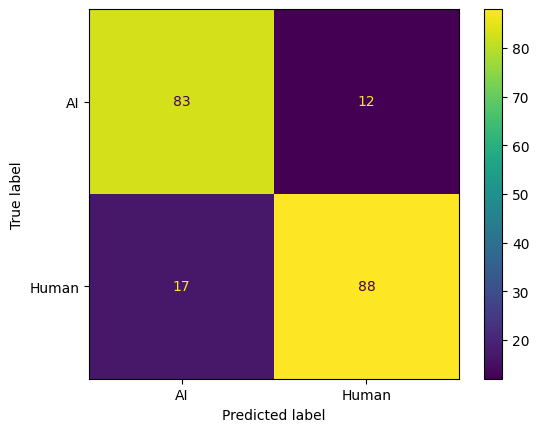

Accuracy: 0.85

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85        95
           1       0.88      0.84      0.86       105

    accuracy                           0.85       200
   macro avg       0.85      0.86      0.85       200
weighted avg       0.86      0.85      0.86       200


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.13
False Negative Rate (FNR): 0.16
True Positive Rate (TPR): 0.84
True Negative Rate (TNR): 0.87

Summary of Errors:
Total Mistakes (FP + FN): 29
Error Rate: 0.14


In [136]:
y_pred_test = random_forest_classifier.predict(X_test)
model_evaluation(y_test, y_pred_test)

# XGBoost 

In [128]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [129]:
xgboost_classifier = XGBClassifier()

In [130]:
xgboost_classifier

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [131]:
xgboost_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

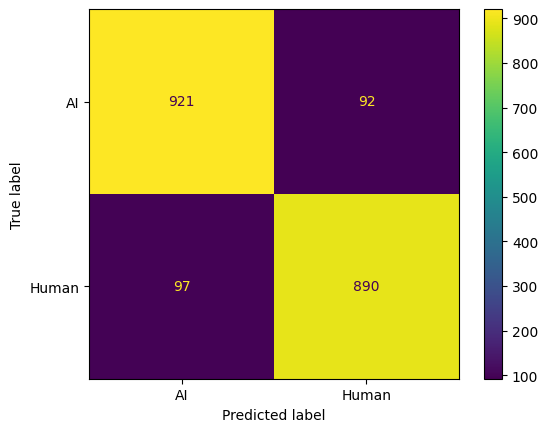


Accuracy: 0.91

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91      1013
           1       0.91      0.90      0.90       987

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.09
False Negative Rate (FNR): 0.10
True Positive Rate (TPR): 0.90
True Negative Rate (TNR): 0.91

Summary of Errors:
Total Mistakes (FP + FN): 189
Error Rate: 0.09


In [132]:
y_pred_test = xgboost_classifier.predict(X_test)
model_evaluation(y_test, y_pred_test)

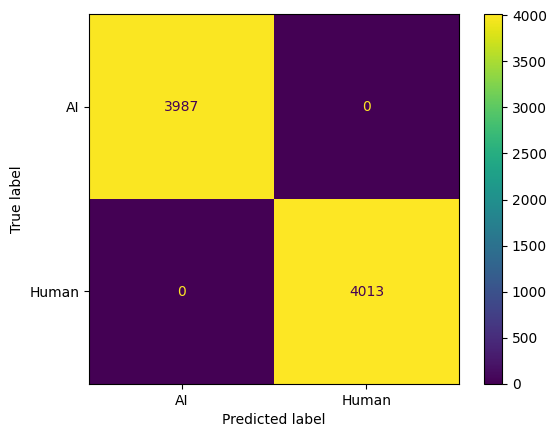


Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3987
           1       1.00      1.00      1.00      4013

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 0.00
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 1.00

Summary of Errors:
Total Mistakes (FP + FN): 0
Error Rate: 0.00


In [133]:
y_pred_train = xgboost_classifier.predict(X_train)
model_evaluation(y_train, y_pred_train)

In [134]:
# Define the parameter search space
search_spaces = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(2, 10),
    'learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.3, 1.0),
    'gamma': Real(0, 0.5),
    'reg_alpha': Real(0, 1.0),
    'reg_lambda': Real(0, 1.0),
    'min_child_weight': Integer(1, 10),
    
}

# Set up the BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=xgboost_classifier,
    search_spaces=search_spaces,
    scoring='accuracy', 
    cv=5,
    n_iter=25,  
    verbose=0,
    random_state=42
)

# Fit to the training data
bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=200, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0, high=1.0, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0, high=1.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1.0, prior='uniform', transform='normalize')})

In [217]:
print("val. score: ", bayes_search.best_score_) #10 iter
print("test score: ", bayes_search.score(X_test, y_test)) 
print("best params: ", bayes_search.best_params_)

val. score:  0.85375
test score:  0.865
best params:  OrderedDict([('colsample_bytree', 0.8596874091250211), ('gamma', 0.21901459322046168), ('learning_rate', 0.05996280567850356), ('max_depth', 8), ('min_child_weight', 9), ('n_estimators', 158), ('reg_alpha', 0.42417807246068207), ('reg_lambda', 0.6502841017477626), ('subsample', 0.7412335382111885)])


In [219]:
print("val. score: ", bayes_search.best_score_) #25 iter
print("test score: ", bayes_search.score(X_test, y_test))
print("best params: ", bayes_search.best_params_)

val. score:  0.865
test score:  0.875
best params:  OrderedDict([('colsample_bytree', 0.7098159680567573), ('gamma', 0.4325903537768684), ('learning_rate', 0.11911146809554733), ('max_depth', 10), ('min_child_weight', 4), ('n_estimators', 200), ('reg_alpha', 0.19045293322755044), ('reg_lambda', 1.0), ('subsample', 0.8851384179544988)])


In [221]:
print("val. score: ", bayes_search.best_score_) #60 iter
print("test score: ", bayes_search.score(X_test, y_test))
print("best params: ", bayes_search.best_params_)

val. score:  0.8675
test score:  0.84
best params:  OrderedDict([('colsample_bytree', 0.7598166505204225), ('gamma', 0.5), ('learning_rate', 0.08580281705462359), ('max_depth', 3), ('min_child_weight', 10), ('n_estimators', 200), ('reg_alpha', 0.0), ('reg_lambda', 0.0), ('subsample', 1.0)])


In [135]:
print("val. score: ", bayes_search.best_score_) #25 iter
print("test score: ", bayes_search.score(X_test, y_test)) 
print("best params: ", bayes_search.best_params_)

val. score:  0.9037499999999999
test score:  0.9135
best params:  OrderedDict([('colsample_bytree', 0.9981051707664326), ('gamma', 0.469819076944712), ('learning_rate', 0.14652183363667018), ('max_depth', 10), ('min_child_weight', 10), ('n_estimators', 200), ('reg_alpha', 0.8999343276827675), ('reg_lambda', 0.07026580469678426), ('subsample', 0.6524891243612454)])


In [136]:
best_model = bayes_search.best_estimator_
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9981051707664326, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.469819076944712,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14652183363667018,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [138]:
best_model.score(X_train, y_train)

0.999625

# MLP Classifier

In [150]:
from sklearn.neural_network import MLPClassifier

In [159]:
mlp_classifier = MLPClassifier(hidden_layer_sizes = (250, 75, 50), 
                               max_iter=50, 
                               random_state=1,
                               verbose = 1,
                              )

In [160]:
mlp_classifier.fit(X_train, y_train)

Iteration 1, loss = 0.47130250
Iteration 2, loss = 0.20864376
Iteration 3, loss = 0.16144444
Iteration 4, loss = 0.13055653
Iteration 5, loss = 0.10304892
Iteration 6, loss = 0.07963900
Iteration 7, loss = 0.05635576
Iteration 8, loss = 0.04194824
Iteration 9, loss = 0.03169981
Iteration 10, loss = 0.02142433
Iteration 11, loss = 0.01321609
Iteration 12, loss = 0.01242706
Iteration 13, loss = 0.01136594
Iteration 14, loss = 0.00966027
Iteration 15, loss = 0.00838217
Iteration 16, loss = 0.01181871
Iteration 17, loss = 0.01089477
Iteration 18, loss = 0.00532297
Iteration 19, loss = 0.01819336
Iteration 20, loss = 0.01947154
Iteration 21, loss = 0.01489616
Iteration 22, loss = 0.00943545
Iteration 23, loss = 0.00578337
Iteration 24, loss = 0.00457181
Iteration 25, loss = 0.00155186
Iteration 26, loss = 0.00320239
Iteration 27, loss = 0.00146434
Iteration 28, loss = 0.00110325
Iteration 29, loss = 0.00084579
Iteration 30, loss = 0.00195403
Iteration 31, loss = 0.00068480
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(250, 75, 50), max_iter=50, random_state=1,
              verbose=1)

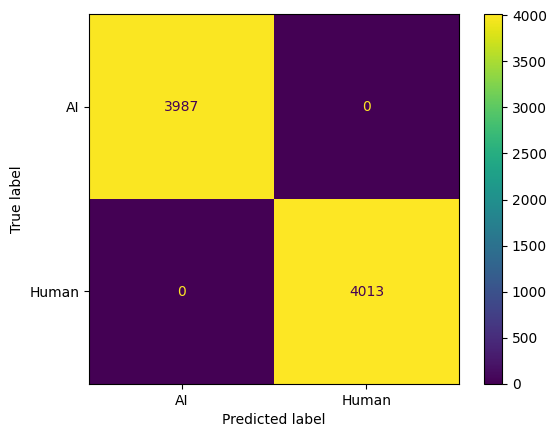


Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3987
           1       1.00      1.00      1.00      4013

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 0.00
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 1.00

Summary of Errors:
Total Mistakes (FP + FN): 0
Error Rate: 0.00


In [161]:
y_pred_train = mlp_classifier.predict(X_train)
model_evaluation(y_train, y_pred_train)

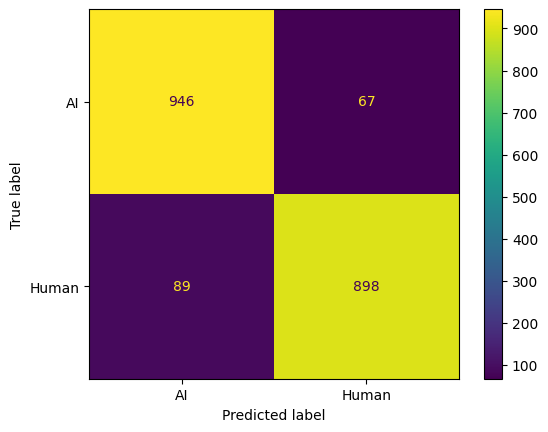


Accuracy: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      1013
           1       0.93      0.91      0.92       987

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.07
False Negative Rate (FNR): 0.09
True Positive Rate (TPR): 0.91
True Negative Rate (TNR): 0.93

Summary of Errors:
Total Mistakes (FP + FN): 156
Error Rate: 0.08


In [162]:
y_pred_test = mlp_classifier.predict(X_test)
model_evaluation(y_test, y_pred_test)